In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [6]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'CNOT'

In [7]:
# no. of levels for each transmon.
N = 2
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[1])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,26.5*(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.           0.        ]
 [  0.           0.          25.32123679   0.        ]
 [  0.          25.32123679 655.39905939   0.        ]
 [  0.           0.           0.         655.39905939]]

In [8]:
if N==3:
    U_targ
    U_targ = np.zeros((N**2,N**2))
    
    U_targ[0][0] = 1
    U_targ[1][1] = 1
    U_targ[2][2] = 1
    U_targ[3][4] = 1
    U_targ[4][3] = 1
    U_targ[5][5] = 1
    U_targ[6][6] = 1
    U_targ[7][7] = 1
    U_targ[8][8] = 1
    U_targ=Qobj(U_targ)
else:
    U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
U_targ

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [9]:
# Duration of each timeslot
#dt = 0.001
# List of evolution times to try
#evo_times = [0.2, 3, 6]
#n_evo_times = len(evo_times)
evo_time = 0.250
n_ts = 250#int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
#results = list()

In [10]:
# Fidelity error target
fid_err_targ = 1e-2
# Maximum iterations for the optisation algorithm
max_iter = 65000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 3200
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [11]:
#Set to None to suppress output files
f_ext = "{}_n_ts_{}_{}_level.txt".format(example_name, n_ts,N)

In [12]:
f_ext

'CNOT_n_ts_250_2_level.txt'

In [13]:
ggg=[[0.000621576, -0.000330512], [-0.002657944, 0.001342436], [-0.01301172, 0.00618256], [-0.03090688, 0.01368984], [-0.0565968, 0.023177], [-0.0898788, 0.03379644], [-0.1297788, 0.0445796], [-0.174288, 0.0544864], [-0.2203636, 0.0624528], [-0.264402, 0.0674288], [-0.303114, 0.0683944], [-0.3344032, 0.0643588], [-0.35775, 0.0543564], [-0.3739548, 0.03747024], [-0.3845204, 0.01292012], [-0.3910596, -0.0197342], [-0.394942, -0.0602636], [-0.397174, -0.1073784], [-0.3984284, -0.158482], [-0.3991228, -0.2098676], [-0.3995052, -0.2575152], [-0.3997156, -0.2982012], [-0.3998324, -0.3303156], [-0.3998984, -0.353946], [-0.399936, -0.370342], [-0.399958, -0.3812048], [-0.3999712, -0.3881624], [-0.3999792, -0.3925192], [-0.3999844, -0.3952128], [-0.399988, -0.3968708], [-0.39999, -0.3978936], [-0.3999916, -0.3985284], [-0.3999928, -0.3989256], [-0.3999936, -0.3991748], [-0.399994, -0.3993296], [-0.3999948, -0.3994216], [-0.3999956, -0.3994672], [-0.399996, -0.3994752], [-0.3999968, -0.399446], [-0.3999976, -0.3993728], [-0.399998, -0.3992388], [-0.3999988, -0.3990104], [-0.3999992, -0.3986252], [-0.3999996, -0.3979652], [-0.3999996, -0.3968056], [-0.4, -0.3947064], [-0.4, -0.3907988], [-0.4, -0.3833564], [-0.4, -0.3690012], [-0.4, -0.341458], [-0.4, -0.2904884], [-0.4, -0.2039852], [-0.4, -0.0784888], [-0.4, 0.0664276], [-0.4, 0.195168], [-0.4, 0.285576], [-0.4, 0.3393324], [-0.4, 0.3683944], [-0.4, 0.3834444], [-0.4, 0.391154], [-0.4, 0.395134], [-0.4, 0.3972264], [-0.4, 0.3983548], [-0.4, 0.3989804], [-0.4, 0.399338], [-0.4, 0.3995488], [-0.4, 0.3996764], [-0.4, 0.3997556], [-0.4, 0.3998056], [-0.4, 0.3998368], [-0.4, 0.3998552], [-0.4, 0.3998648], [-0.4, 0.3998672], [-0.4, 0.3998624], [-0.4, 0.39985], [-0.4, 0.3998288], [-0.4, 0.3997952], [-0.4, 0.3997436], [-0.4, 0.3996652], [-0.4, 0.399546], [-0.4, 0.399362], [-0.4, 0.3990732], [-0.4, 0.3986148], [-0.4, 0.3978772], [-0.4, 0.3966788], [-0.4, 0.3947188], [-0.4, 0.3915044], [-0.4, 0.3862492], [-0.4, 0.3777356], [-0.4, 0.3641824], [-0.3999996, 0.3431884], [-0.3999976, 0.3119396], [-0.399986, 0.267888], [-0.3999288, 0.209978], [-0.3996872, 0.1399596], [-0.3988372, 0.062772], [-0.3963504, -0.01475396], [-0.3903288, -0.0862604], [-0.3783236, -0.1477096], [-0.3587148, -0.1977696], [-0.3325072, -0.2370836], [-0.3037656, -0.2672744], [-0.2778824, -0.290194], [-0.259186, -0.3075324], [-0.2496864, -0.3206776], [-0.2491776, -0.3307092], [-0.2559684, -0.3384472], [-0.2676748, -0.344508], [-0.281864, -0.3493584], [-0.2964916, -0.353354], [-0.3101168, -0.3567692], [-0.3219152, -0.3598164], [-0.331552, -0.3626576], [-0.3390124, -0.3654108], [-0.3444456, -0.3681536], [-0.3480508, -0.3709248], [-0.3500132, -0.3737292], [-0.3504728, -0.376542], [-0.3495124, -0.3793168], [-0.3471672, -0.3819944], [-0.3434368, -0.3845152], [-0.338312, -0.3868268], [-0.3318048, -0.3888912], [-0.3239856, -0.3906876], [-0.315024, -0.3922124], [-0.3052168, -0.3934764], [-0.2950016, -0.3945008], [-0.28494, -0.3953104], [-0.27567, -0.3959332], [-0.2678356, -0.3963932], [-0.2620044, -0.39671], [-0.2585948, -0.3968968], [-0.2578212, -0.3969576], [-0.2596712, -0.3968844], [-0.2639152, -0.3966536], [-0.2701408, -0.3962172], [-0.2778144, -0.3954872], [-0.2863464, -0.3943092], [-0.295164, -0.392412], [-0.3037636, -0.3893116], [-0.311746, -0.3841356], [-0.3188264, -0.3753048], [-0.324828, -0.3599904], [-0.3296568, -0.333338], [-0.3332784, -0.2878656], [-0.335692, -0.21465], [-0.336908, -0.1092296], [-0.336936, 0.01860192], [-0.3357768, 0.1438044], [-0.3334232, 0.242904], [-0.3298664, 0.3090152], [-0.3251092, 0.3484512], [-0.3191888, 0.370622], [-0.3121996, 0.3828172], [-0.3043216, 0.3895372], [-0.295842, 0.3932976], [-0.2871636, 0.3954468], [-0.278796, 0.3967004], [-0.2713204, 0.397438], [-0.2653336, 0.3978632], [-0.261382, 0.3980828], [-0.2598868, 0.39815], [-0.2610864, 0.3980836], [-0.2649952, 0.3978744], [-0.2713948, 0.3974876], [-0.2798548, 0.3968512], [-0.2897884, 0.3958444], [-0.300528, 0.394266], [-0.3114128, 0.3917976], [-0.3218676, 0.3879436], [-0.3314512, 0.3819636], [-0.3398776, 0.3728124], [-0.347004, 0.359132], [-0.3527968, 0.3393792], [-0.3572936, 0.3121624], [-0.3605624, 0.2767988], [-0.3626708, 0.2339032], [-0.3636604, 0.1856448], [-0.3635276, 0.1353824], [-0.3622092, 0.0867868], [-0.3595696, 0.042922], [-0.3553848, 0.00573556], [-0.3493348, -0.02395464], [-0.3409968, -0.0461796], [-0.329858, -0.0614776], [-0.3153568, -0.070628], [-0.2969676, -0.0744976], [-0.2743396, -0.0739688], [-0.2474688, -0.0699176], [-0.2168576, -0.0632104], [-0.1835888, -0.0546988], [-0.1492416, -0.0452036], [-0.1156544, -0.03548812], [-0.0846132, -0.0262242], [-0.0575744, -0.01796052], [-0.03550828, -0.01109728], [-0.018871, -0.00587164], [-0.0076584, -0.002352924], [-0.001488892, -0.000446852]]
#print(ggg)
#plt.plot(ggg)

0.009997146890037945


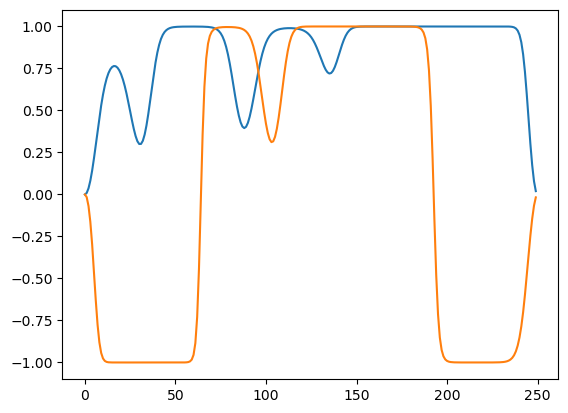

[[-1.65580904  2.6321973 ]
 [ 0.60889201  1.49742584]
 [ 8.41003563  0.43924002]
 [-0.84143204  0.06137988]] [ 21.76631653 114.70169934   5.00701712  66.08989366]
[[-9.18232101 -2.72403595]
 [-2.97394836 -2.80109747]
 [ 0.70133721 -0.779471  ]
 [-3.4090461  -1.20583874]] [ 31.75916436  51.36819235 113.89391654  70.28800543]


In [50]:
GUESS= np.zeros([n_ts, n_ctrls])
for om in range(1):
    optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                    amp_lbound=-1 , amp_ubound=1 , 
                    fid_err_targ=fid_err_targ, 
                    max_iter=max_iter, max_wall_time=max_wall_time,
                    alg='CRAB', 
                    dyn_type='UNIT', 
                    prop_type='DIAG', 
                    fid_type='UNIT', fid_params={'phase_option':'PSU'},gen_stats=True)
    
    dyn = optim.dynamics
    crab_pgen = optim.pulse_generator[0]
    # Apply a ramping pulse that will force the start and end to zero
    ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                        pulse_params={'decay_time':evo_time/500.0})
    crab_pgen.guess_pulse_action='ADD'
    crab_pgen.guess_pulse=GUESS[:,0]
    crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()
    
    
    crab_pgen = optim.pulse_generator[1]
    # Apply a ramping pulse that will force the start and end to zero
    ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                        pulse_params={'decay_time':evo_time/500.0})
    
    crab_pgen.guess_pulse_action='ADD'
    crab_pgen.guess_pulse=GUESS[:,1]
    fff=ramp_pgen.gen_pulse()
    crab_pgen.ramping_pulse = fff
    
    
    init_amps = np.zeros([n_ts, n_ctrls])
    for j in range(dyn.num_ctrls):
        pgen = optim.pulse_generator[j]
        pgen.num_coeffs=4
        pgen.init_pulse()
        pgen.freqs=np.random.randint(1,150,pgen.num_coeffs)+np.random.random(pgen.num_coeffs) - 0.5#np.random.randint(om*50+1,om*50+50,pgen.num_coeffs)+np.random.random(pgen.num_coeffs) - 0.5
        np.sort(pgen.freqs)
        #print(pgen.coeffs,pgen.freqs)
        #plt.plot(pgen.guess_pulse)
        init_amps[:, j] = pgen.gen_pulse()
    #init_amps=ggg
    dyn.initialize_controls(init_amps)
    #plt.plot(init_amps[:])
    
    result = optim.run_optimization()
    print(result.fid_err)
    plt.plot(result.final_amps[:])
    plt.show()
    for j in range(dyn.num_ctrls):
        pgen = optim.pulse_generator[j]
        for i in range(pgen.num_coeffs):
            phase = pgen.freqs[i] * pgen.time
            GUESS[:,j] += pgen.coeffs[i, 0] * np.sin(phase) + pgen.coeffs[i, 1] * np.cos(phase)
        print(pgen.coeffs,pgen.freqs)

In [62]:
from scipy.linalg import expm
U=identity(4)
fid=[]
for i in range(len(c1)):
    U=Qobj(expm(0.001*1j*(H_d.full()+c1[i]*H_c[0].full()+c2[i]*H_c[1].full())))*U
U/U[0][0]

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+5.55111512e-17j  2.99603827e-04+1.18674405e-01j
   5.15172908e-03+1.85142386e-03j -3.24603863e-02-1.01687126e-02j]
 [ 3.58412377e-03+1.18365267e-01j  9.97596263e-01-1.82238169e-02j
  -6.26670330e-02-1.25475861e-02j  3.83585954e-02+1.26955593e-02j]
 [ 3.23177915e-02-1.23041757e-02j -3.89846691e-02+6.72535301e-03j
   3.36549094e-03-1.34015259e-01j  9.95801031e-01+5.40256946e-02j]
 [-5.34006635e-03+4.81878221e-03j  6.35235251e-02-7.50753605e-03j
   9.96272649e-01+2.50115526e-02j  1.00163358e-02-1.33575139e-01j]]

In [57]:
c1=np.array([-2.39217832e-54,  9.27012109e-03,  3.68570800e-02,  8.17612490e-02,
        1.41934755e-01,  2.14134107e-01,  2.93999787e-01,  3.76486901e-01,
        4.56593651e-01,  5.30139131e-01,  5.94287269e-01,  6.47653835e-01,
        6.90050306e-01,  7.22050463e-01,  7.44561211e-01,  7.58498402e-01,
        7.64589526e-01,  7.63283293e-01,  7.54738577e-01,  7.38875457e-01,
        7.15484807e-01,  6.84400382e-01,  6.45731331e-01,  6.00129949e-01,
        5.49034325e-01,  4.94798074e-01,  4.40628616e-01,  3.90316041e-01,
        3.47820907e-01,  3.16844304e-01,  3.00485345e-01,  3.01014039e-01,
        3.19707362e-01,  3.56666823e-01,  4.10579594e-01,  4.78492660e-01,
        5.55792226e-01,  6.36620035e-01,  7.14806819e-01,  7.85080764e-01,
        8.44052088e-01,  8.90550980e-01,  9.25274166e-01,  9.50047261e-01,
        9.67085212e-01,  9.78479105e-01,  9.85946982e-01,  9.90778641e-01,
        9.93883957e-01,  9.95877317e-01,  9.97161115e-01,  9.97993545e-01,
        9.98538161e-01,  9.98897857e-01,  9.99137185e-01,  9.99296618e-01,
        9.99401477e-01,  9.99467438e-01,  9.99503871e-01,  9.99515782e-01,
        9.99504842e-01,  9.99469743e-01,  9.99405969e-01,  9.99304960e-01,
        9.99152462e-01,  9.98925735e-01,  9.98589032e-01,  9.98086440e-01,
        9.97330786e-01,  9.96186810e-01,  9.94446405e-01,  9.91793771e-01,
        9.87759407e-01,  9.81665323e-01,  9.72571043e-01,  9.59242142e-01,
        9.40178896e-01,  9.13754987e-01,  8.78509355e-01,  8.33588366e-01,
        7.79245619e-01,  7.17211331e-01,  6.50724290e-01,  5.84137554e-01,
        5.22215553e-01,  4.69386956e-01,  4.29196759e-01,  4.04050353e-01,
        3.95189498e-01,  4.02774303e-01,  4.25968984e-01,  4.62997854e-01,
        5.11207360e-01,  5.67209202e-01,  6.27168434e-01,  6.87235985e-01,
        7.44036838e-01,  7.95070197e-01,  8.38900602e-01,  8.75107691e-01,
        9.04057036e-01,  9.26600029e-01,  9.43797685e-01,  9.56719288e-01,
        9.66324505e-01,  9.73412887e-01,  9.78617250e-01,  9.82420279e-01,
        9.85180023e-01,  9.87156013e-01,  9.88532011e-01,  9.89434067e-01,
        9.89943831e-01,  9.90107633e-01,  9.89941934e-01,  9.89435629e-01,
        9.88549543e-01,  9.87213309e-01,  9.85319716e-01,  9.82716799e-01,
        9.79198267e-01,  9.74493752e-01,  9.68261784e-01,  9.60090528e-01,
        9.49513785e-01,  9.36051827e-01,  9.19286260e-01,  8.98972906e-01,
        8.75184514e-01,  8.48456947e-01,  8.19894967e-01,  7.91188013e-01,
        7.64501814e-01,  7.42246220e-01,  7.26757180e-01,  7.19951984e-01,
        7.23015131e-01,  7.36159309e-01,  7.58499833e-01,  7.88086287e-01,
        8.22133753e-01,  8.57458435e-01,  8.91040692e-01,  9.20553796e-01,
        9.44681443e-01,  9.63134244e-01,  9.76412574e-01,  9.85456009e-01,
        9.91320829e-01,  9.94964370e-01,  9.97145674e-01,  9.98411452e-01,
        9.99127472e-01,  9.99524530e-01,  9.99741572e-01,  9.99859153e-01,
        9.99922616e-01,  9.99956917e-01,  9.99975570e-01,  9.99985823e-01,
        9.99991542e-01,  9.99994790e-01,  9.99996674e-01,  9.99997792e-01,
        9.99998471e-01,  9.99998893e-01,  9.99999160e-01,  9.99999332e-01,
        9.99999442e-01,  9.99999510e-01,  9.99999549e-01,  9.99999565e-01,
        9.99999560e-01,  9.99999536e-01,  9.99999490e-01,  9.99999417e-01,
        9.99999311e-01,  9.99999161e-01,  9.99998951e-01,  9.99998660e-01,
        9.99998260e-01,  9.99997715e-01,  9.99996979e-01,  9.99996002e-01,
        9.99994730e-01,  9.99993116e-01,  9.99991132e-01,  9.99988788e-01,
        9.99986148e-01,  9.99983344e-01,  9.99980582e-01,  9.99978120e-01,
        9.99976238e-01,  9.99975183e-01,  9.99975116e-01,  9.99976072e-01,
        9.99977943e-01,  9.99980506e-01,  9.99983469e-01,  9.99986530e-01,
        9.99989430e-01,  9.99991992e-01,  9.99994121e-01,  9.99995802e-01,
        9.99997071e-01,  9.99997992e-01,  9.99998641e-01,  9.99999086e-01,
        9.99999385e-01,  9.99999583e-01,  9.99999713e-01,  9.99999799e-01,
        9.99999854e-01,  9.99999891e-01,  9.99999915e-01,  9.99999930e-01,
        9.99999939e-01,  9.99999944e-01,  9.99999944e-01,  9.99999941e-01,
        9.99999932e-01,  9.99999916e-01,  9.99999888e-01,  9.99999839e-01,
        9.99999750e-01,  9.99999581e-01,  9.99999249e-01,  9.99998565e-01,
        9.99997097e-01,  9.99993823e-01,  9.99986302e-01,  9.99968610e-01,
        9.99926371e-01,  9.99824913e-01,  9.99581993e-01,  9.99007660e-01,
        9.97679363e-01,  9.94702652e-01,  9.88301583e-01,  9.75231055e-01,
        9.50187225e-01,  9.05782146e-01,  8.34074149e-01,  7.30330534e-01,
        5.97686412e-01,  4.48863274e-01,  3.02273374e-01,  1.75166767e-01,
        7.91360658e-02,  1.99777429e-02])

In [59]:
c2=np.array([ 3.88021085e-54, -1.61850612e-02, -6.89361407e-02, -1.62690062e-01,
       -2.96617142e-01, -4.59749643e-01, -6.28733391e-01, -7.75121258e-01,
       -8.80294227e-01, -9.43517547e-01, -9.76024532e-01, -9.90696735e-01,
       -9.96649606e-01, -9.98864157e-01, -9.99632472e-01, -9.99884927e-01,
       -9.99964655e-01, -9.99989204e-01, -9.99996677e-01, -9.99998956e-01,
       -9.99999661e-01, -9.99999885e-01, -9.99999959e-01, -9.99999984e-01,
       -9.99999994e-01, -9.99999997e-01, -9.99999999e-01, -9.99999999e-01,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -9.99999999e-01, -9.99999999e-01, -9.99999998e-01, -9.99999996e-01,
       -9.99999992e-01, -9.99999983e-01, -9.99999961e-01, -9.99999906e-01,
       -9.99999766e-01, -9.99999397e-01, -9.99998399e-01, -9.99995647e-01,
       -9.99987938e-01, -9.99966087e-01, -9.99903750e-01, -9.99725622e-01,
       -9.99218384e-01, -9.97786769e-01, -9.93806685e-01, -9.82994508e-01,
       -9.54657228e-01, -8.84678987e-01, -7.29121461e-01, -4.41390693e-01,
       -4.03331195e-02,  3.55689392e-01,  6.41701818e-01,  8.09400235e-01,
        8.98249031e-01,  9.43946863e-01,  9.67661319e-01,  9.80307939e-01,
        9.87290148e-01,  9.91285064e-01,  9.93644591e-01,  9.95069432e-01,
        9.95932279e-01,  9.96434872e-01,  9.96685632e-01,  9.96738369e-01,
        9.96611005e-01,  9.96293194e-01,  9.95746752e-01,  9.94900206e-01,
        9.93637205e-01,  9.91777504e-01,  9.89048484e-01,  9.85045174e-01,
        9.79177978e-01,  9.70611376e-01,  9.58205450e-01,  9.40486937e-01,
        9.15696263e-01,  8.81972829e-01,  8.37731865e-01,  7.82224676e-01,
        7.16152918e-01,  6.42082382e-01,  5.64391938e-01,  4.88679257e-01,
        4.20834659e-01,  3.66160615e-01,  3.28824770e-01,  3.11687315e-01,
        3.16337353e-01,  3.43113279e-01,  3.90954536e-01,  4.57088033e-01,
        5.36752335e-01,  6.23326007e-01,  7.09183738e-01,  7.87219141e-01,
        8.52428877e-01,  9.02762595e-01,  9.38885899e-01,  9.63182183e-01,
        9.78626023e-01,  9.87979143e-01,  9.93416479e-01,  9.96471207e-01,
        9.98139861e-01,  9.99031119e-01,  9.99499026e-01,  9.99741684e-01,
        9.99866583e-01,  9.99930679e-01,  9.99963616e-01,  9.99980632e-01,
        9.99989504e-01,  9.99994189e-01,  9.99996703e-01,  9.99998077e-01,
        9.99998845e-01,  9.99999283e-01,  9.99999539e-01,  9.99999693e-01,
        9.99999788e-01,  9.99999848e-01,  9.99999887e-01,  9.99999912e-01,
        9.99999929e-01,  9.99999941e-01,  9.99999949e-01,  9.99999954e-01,
        9.99999957e-01,  9.99999959e-01,  9.99999959e-01,  9.99999958e-01,
        9.99999956e-01,  9.99999953e-01,  9.99999948e-01,  9.99999941e-01,
        9.99999932e-01,  9.99999920e-01,  9.99999904e-01,  9.99999884e-01,
        9.99999858e-01,  9.99999823e-01,  9.99999778e-01,  9.99999718e-01,
        9.99999639e-01,  9.99999534e-01,  9.99999393e-01,  9.99999203e-01,
        9.99998945e-01,  9.99998592e-01,  9.99998104e-01,  9.99997423e-01,
        9.99996460e-01,  9.99995083e-01,  9.99993086e-01,  9.99990148e-01,
        9.99985757e-01,  9.99979087e-01,  9.99968773e-01,  9.99952535e-01,
        9.99926477e-01,  9.99883835e-01,  9.99812634e-01,  9.99691292e-01,
        9.99480182e-01,  9.99105235e-01,  9.98425588e-01,  9.97168960e-01,
        9.94801337e-01,  9.90262975e-01,  9.81436129e-01,  9.64096205e-01,
        9.29970193e-01,  8.63680966e-01,  7.39984567e-01,  5.28225046e-01,
        2.17109291e-01, -1.48261066e-01, -4.78311977e-01, -7.12433540e-01,
       -8.51521917e-01, -9.25739845e-01, -9.63212617e-01, -9.81699709e-01,
       -9.90777803e-01, -9.95263028e-01, -9.97507910e-01, -9.98651538e-01,
       -9.99246687e-01, -9.99563977e-01, -9.99737652e-01, -9.99835405e-01,
       -9.99892018e-01, -9.99925735e-01, -9.99946337e-01, -9.99959183e-01,
       -9.99967274e-01, -9.99972312e-01, -9.99975268e-01, -9.99976673e-01,
       -9.99976780e-01, -9.99975629e-01, -9.99973069e-01, -9.99968732e-01,
       -9.99961948e-01, -9.99951605e-01, -9.99935890e-01, -9.99911859e-01,
       -9.99874725e-01, -9.99816678e-01, -9.99724941e-01, -9.99578598e-01,
       -9.99343454e-01, -9.98963805e-01, -9.98349428e-01, -9.97355355e-01,
       -9.95751023e-01, -9.93174395e-01, -9.89065979e-01, -9.82578447e-01,
       -9.72462046e-01, -9.56938299e-01, -9.33600520e-01, -8.99423671e-01,
       -8.51019625e-01, -7.85295175e-01, -7.00571354e-01, -5.97924747e-01,
       -4.82112364e-01, -3.61336344e-01, -2.45667804e-01, -1.44882951e-01,
       -6.68721367e-02, -1.72590393e-02])

In [54]:
pgen.freqs,pgen.coeffs

(array([ 31.75916436,  51.36819235, 113.89391654,  70.28800543]),
 array([[-9.18232101, -2.72403595],
        [-2.97394836, -2.80109747],
        [ 0.70133721, -0.779471  ],
        [-3.4090461 , -1.20583874]]))

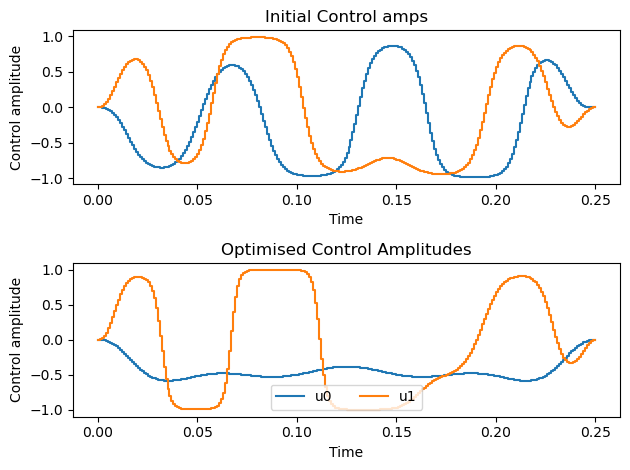

In [40]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post', label='u{}'.format(j))
ax2.legend(loc=8, ncol=n_ctrls)
plt.tight_layout()
plt.show()


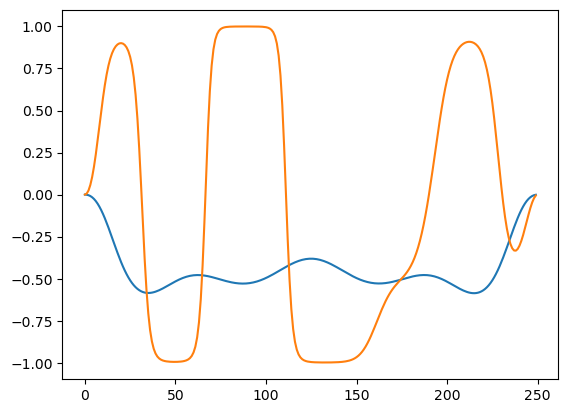

In [41]:
plt.plot(np.tanh(GUESS[:,0]*fff))
plt.plot(np.tanh(GUESS[:,1]*fff))
#np.tanh(GUESS[:,1]*fff)

In [42]:
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))

Initial fidelity error 0.5187332262566664
Final fidelity error 0.1034958547656345
Terminated due to Function converged (within tolerance)
Number of iterations 1067
Completed in 0:02:37.714338 HH:MM:SS.US


In [43]:
U=result.evo_full_final
print("Fidelity : ",1-result.fid_err)
U*np.exp(-1j*cmath.polar(U[0][0])[1])*U*np.exp(-1j*cmath.polar(U[0][0])[1])

Fidelity :  0.8965041452343655


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 6.46797410e-01+1.00451777e-03j  5.80351736e-03+7.62012514e-01j
  -5.59799948e-04-3.08159588e-02j  9.52644034e-04-2.12253371e-03j]
 [ 2.80456968e-03+7.62169191e-01j  6.46548319e-01-8.86867634e-03j
  -6.08097968e-03-1.26550375e-02j -1.64034992e-02-2.28182568e-02j]
 [-7.48737622e-04-2.72184404e-02j -3.56841536e-03-1.51652371e-02j
   5.28378256e-01-3.72083769e-01j -4.33633520e-01-6.27174565e-01j]
 [-9.65375381e-04+1.55535878e-04j -1.62013934e-02-2.63564392e-02j
  -4.35824936e-01-6.25523499e-01j  5.33848961e-01-3.64450491e-01j]]

In [44]:
pgen.freqs,pgen.coeffs,pgen.get_optim_var_vals()

(array([63.7541107 , 91.06119583]),
 array([[-0.53572224,  2.49066104],
        [ 1.69236362,  0.01895622]]),
 [-0.5357222356440083,
  2.4906610382173344,
  1.6923636178145662,
  0.018956221482931898])

In [277]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "F0_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

Initial amplitudes output to file: ctrl_amps_initial_CNOT_n_ts_200_2_level.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: F0_CNOT_n_ts_200_2_level.txt


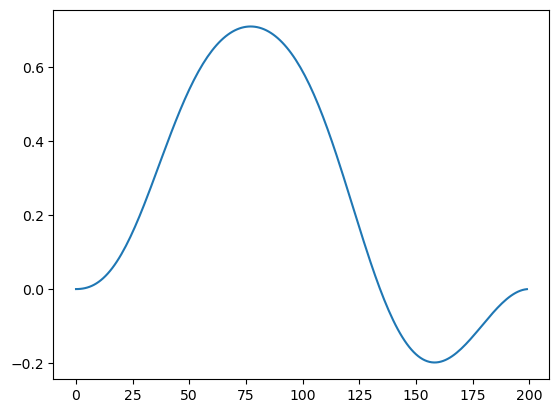

In [188]:

pulse=pgen.gen_pulse()
#plt.plot(pgen.gen_pulse())
pgen.guess_pulse_action='ADD'
pgen.guess_pulse=50*np.ones(pgen.num_tslots)
pulse=pgen.gen_pulse()
plt.plot(pulse)

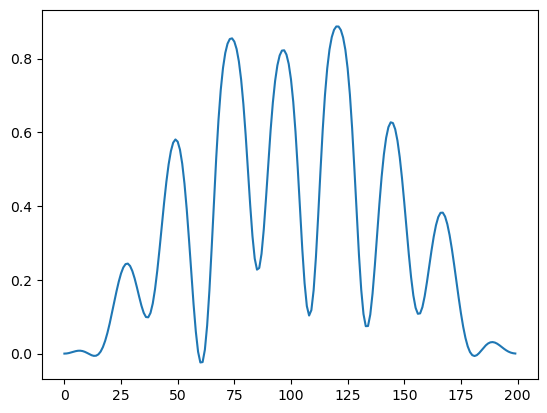

In [139]:
pgen.guess_pulse_action='ADD'
pgen.guess_pulse=np.array([-7.20088626e-05,  3.14812087e-04,  1.42941892e-03,  3.07040591e-03,
         4.91604445e-03,  6.57346789e-03,  7.64395818e-03,  7.79598303e-03,
         6.83630535e-03,  4.76930381e-03,  1.83557232e-03, -1.47719413e-03,
        -4.45515115e-03, -6.21156770e-03, -5.76887413e-03, -2.16239078e-03,
         5.44379117e-03,  1.76394979e-02,  3.46612532e-02,  5.63081719e-02,
         8.18960927e-02,  1.10265469e-01,  1.39853490e-01,  1.68828414e-01,
         1.95267278e-01,  2.17345437e-01,  2.33506115e-01,  2.42591729e-01,
         2.43938457e-01,  2.37448993e-01,  2.23657195e-01,  2.03782039e-01,
         1.79745958e-01,  1.54119163e-01,  1.29960194e-01,  1.10554413e-01,
         9.90882265e-02,  9.83115752e-02,  1.10224197e-01,  1.35792299e-01,
         1.74698392e-01,  2.25168889e-01,  2.83986665e-01,  3.46806914e-01,
         4.08789868e-01,  4.65376249e-01,  5.12909040e-01,  5.48873250e-01,
         5.71735841e-01,  5.80552867e-01,  5.74567779e-01,  5.52986688e-01,
         5.15060975e-01,  4.60555283e-01,  3.90570256e-01,  3.08457873e-01,
         2.20295777e-01,  1.34395217e-01,  5.98570374e-02,  4.90679430e-03,
        -2.41367351e-02, -2.30512258e-02,  1.04055741e-02,  7.61742723e-02,
         1.70830974e-01,  2.86417760e-01,  4.10693332e-01,  5.29921196e-01,
         6.33082412e-01,  7.14656487e-01,  7.74384214e-01,  8.15059056e-01,
         8.40244619e-01,  8.52868827e-01,  8.54641715e-01,  8.45923231e-01,
         8.25785243e-01,  7.92245675e-01,  7.42866281e-01,  6.75989646e-01,
         5.92618184e-01,  4.98171459e-01,  4.02683241e-01,  3.18644779e-01,
         2.57604891e-01,  2.27583710e-01,  2.32149791e-01,  2.70425028e-01,
         3.37153861e-01,  4.23010422e-01,  5.16066748e-01,  6.04675881e-01,
         6.80436998e-01,  7.39451741e-01,  7.81495119e-01,  8.08199697e-01,
         8.21433258e-01,  8.22310913e-01,  8.10739126e-01,  7.85303177e-01,
         7.43491679e-01,  6.82492814e-01,  6.00862487e-01,  5.00894202e-01,
         3.90438665e-01,  2.82325774e-01,  1.91020909e-01,  1.28694115e-01,
         1.03161405e-01,  1.17837031e-01,  1.72051350e-01,  2.60520307e-01,
         3.72543457e-01,  4.92977614e-01,  6.06207575e-01,  7.01121607e-01,
         7.73459478e-01,  8.24467418e-01,  8.57928801e-01,  8.77768655e-01,
         8.86864870e-01,  8.86686565e-01,  8.77259301e-01,  8.57191277e-01,
         8.23759912e-01,  7.73304840e-01,  7.02356316e-01,  6.09775033e-01,
         4.99297695e-01,  3.80639148e-01,  2.67479721e-01,  1.73190453e-01,
         1.07262591e-01,  7.42782914e-02,  7.47140100e-02,  1.05971005e-01,
         1.62849604e-01,  2.37764844e-01,  3.21444813e-01,  4.04446250e-01,
         4.78956112e-01,  5.39922783e-01,  5.85041503e-01,  6.13912767e-01,
         6.27019790e-01,  6.24981634e-01,  6.08233874e-01,  5.77116098e-01,
         5.32285053e-01,  4.75313594e-01,  4.09228689e-01,  3.38663482e-01,
         2.69402428e-01,  2.07419156e-01,  1.57816400e-01,  1.24091222e-01,
         1.07875328e-01,  1.09021407e-01,  1.25832492e-01,  1.55331155e-01,
         1.93587154e-01,  2.36153344e-01,  2.78590296e-01,  3.16966945e-01,
         3.48200737e-01,  3.70171146e-01,  3.81645857e-01,  3.82123704e-01,
         3.71696131e-01,  3.50981783e-01,  3.21130649e-01,  2.83848214e-01,
         2.41369912e-01,  1.96330753e-01,  1.51521580e-01,  1.09580038e-01,
         7.26976997e-02,  4.24156370e-02,  1.95398707e-02,  4.16507769e-03,
        -4.22769340e-03, -6.63349338e-03, -4.36916499e-03,  1.08472731e-03,
         8.23643945e-03,  1.57199452e-02,  2.24050804e-02,  2.74716438e-02,
         3.04428014e-02,  3.11786906e-02,  2.98356642e-02,  2.67994885e-02,
         2.26023304e-02,  1.78340757e-02,  1.30584988e-02,  8.74382677e-03,
         5.21509468e-03,  2.63258514e-03,  9.97065659e-04,  1.79072356e-04])
plt.plot(pgen.guess_pulse)

In [54]:
pgen.freqs,pgen.get_optim_var_vals()

(array([ 51.71013326, 247.55901706, 125.84702195]),
 [0.6578427915515768,
  0.027902900831474176,
  0.5638994420017367,
  0.34179190899972456,
  0.750475855244392,
  0.004960162587814176])

In [61]:
pgen.freqs,pgen.coeffs

(array([ 51.71013326, 247.55901706, 125.84702195]),
 array([[-1.29484452,  0.26807789],
        [-0.72692503,  1.59778826],
        [ 2.6346611 , -0.01183116]]))

200

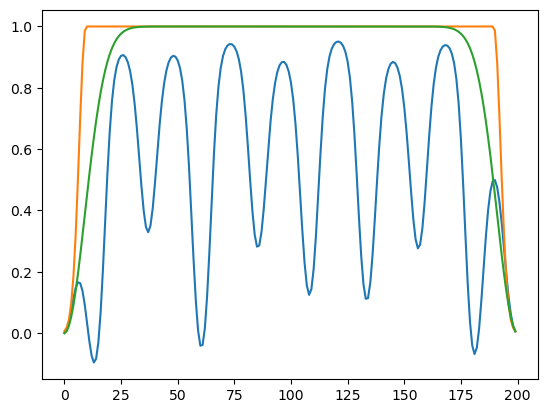

In [129]:
from scipy.signal.windows import gaussian
pulse = np.zeros(pgen.num_tslots)
for i in range(pgen.num_coeffs):
    phase = pgen.freqs[i] * pgen.time
    pulse += pgen.coeffs[i, 0] * np.sin(phase) + pgen.coeffs[i, 1] * np.cos(phase)
fff=(1/0.1936)*np.array([0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347])
ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                    pulse_params={'decay_time':0.2/1200})
hhh=ramp_pgen.gen_pulse()
pulse = pulse * hhh
pulse = np.tanh(pulse)
plt.plot(pulse)
plt.plot(fff)
plt.plot(hhh)
len(fff)

In [118]:
?np.tanh

Call signature:  np.tanh(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'tanh'>
File:            c:\programdata\anaconda3\lib\site-packages\numpy\__init__.py
Docstring:      
tanh(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Compute hyperbolic tangent element-wise.

Equivalent to ``np.sinh(x)/np.cosh(x)`` or ``-1j * np.tan(1j*x)``.

Parameters
----------
x : array_like
    Input array.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True, the `out` array will be set to the ufunc result.
    Elsewhere, 

In [38]:
dd[1]-pgen.get_optim_var_vals()[1]

0.08783750245318811